In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_trajectories
import matplotlib.pyplot as plt
from example_utils import reject_outliers, initial_conditions, plot_phase_portrait, plot_phase_portrait

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

ModuleNotFoundError: No module named 'modules'

In [2]:
def simulate_system(mu, X0, t):
    p, v = simulate_trajectories('vanderpol', X0, t, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        vel.append(v_[ind])
        
    return pos, vel

def parabola(X, Y, alpha=0.05):
    Z = -(alpha*X)**2 -(alpha*Y)**2
    
    return np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])

# For initial conditions, sample a rectangle uniformly

In [3]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [33]:
n_steps=20
beta1 = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), area)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
#embed on parabola
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = parabola(end_point[:,0], end_point[:,1])
    pos[i] = parabola(p[:,0], p[:,1])
    vel[i] = new_endpoint - pos[i]

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


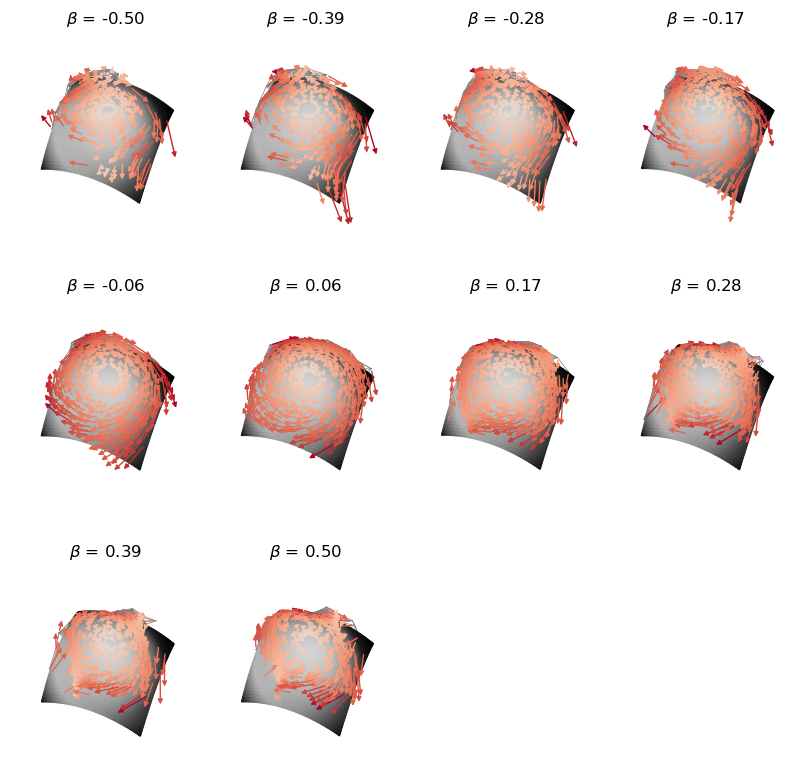

In [6]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]

#plotting.fields(data, col=4, alpha=0.3, scale=10)
axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])

from matplotlib.colors import LightSource

x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
xyz = np.array(parabola(np.ravel(X), np.ravel(Y)))
ls = LightSource(azdeg=30,altdeg=30)
rgb = ls.shade(xyz[:,2].reshape(X.shape)-0.1, plt.cm.gray)

for ax in axes:
    ax.plot_surface(xyz[:,0].reshape(X.shape), xyz[:,1].reshape(X.shape), xyz[:,2].reshape(X.shape)-0.02, 
                color='gray', 
                shade=True,
                lightsource=ls,
                facecolors=rgb
               )
    
ax = plot_phase_portrait(X, 
                    V, 
                    style='->', 
                    node_feature=[[i]*len(p) for i, p in enumerate(X)], 
                    lw=1,
                    ah=10,
                    spacing=5)

N=50

# ax.view_init(elev=30, azim=45)
X_emb = np.vstack(X)

ind, lamb = geometry.furthest_point_sampling(X_emb, N)

ind = np.array(list(set(ind)))
_, nn = find_nn(ind, X_emb, nn=2)

for i, nn_ in enumerate(nn):
    ax = circle(ax, 2, X_emb[[ind[i]] + list(nn_)], col='k')
    
#plt.savefig('./outputs/parabolas.svg')

# Train network